## Import Library

In [1]:
!pip install jcopdl
!pip install gdown

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16924 sha256=a73126393c0a755688c756cd063fe3381820b7f4262530fcbf5c1f5692b0b407
  Stored in directory: /root/.cache/pip/wheels/e5/78/9d/931694cba38491e16f1a94719193211fd12a7307570d9bb562
Successfully built jcopdl


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/data_disaster.zip

Archive:  /content/drive/MyDrive/data_disaster.zip
   creating: data_disaster/
   creating: data_disaster/test/
   creating: data_disaster/test/cyclone/
  inflating: data_disaster/test/cyclone/500.jpg  
  inflating: data_disaster/test/cyclone/501.jpg  
  inflating: data_disaster/test/cyclone/502.jpg  
  inflating: data_disaster/test/cyclone/503.jpg  
  inflating: data_disaster/test/cyclone/504.jpg  
  inflating: data_disaster/test/cyclone/505.jpg  
  inflating: data_disaster/test/cyclone/506.jpg  
  inflating: data_disaster/test/cyclone/507.jpg  
  inflating: data_disaster/test/cyclone/508.jpg  
  inflating: data_disaster/test/cyclone/509.jpg  
  inflating: data_disaster/test/cyclone/510.jpg  
  inflating: data_disaster/test/cyclone/511.jpg  
  inflating: data_disaster/test/cyclone/512.jpg  
  inflating: data_disaster/test/cyclone/513.jpg  
  inflating: data_disaster/test/cyclone/514.jpg  
  inflating: data_disaster/test/cyclone/515.jpg  
  inflating: data_disaster/test/cyclone/516.jpg

In [5]:
import torch
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset dan dataloader

In [9]:
bs = 128
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = datasets.ImageFolder("/content/data_disaster/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("/content/data_disaster/validation", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [10]:
label2cat = train_set.classes
label2cat

['cyclone', 'earthquake', 'flood', 'wildfire']

## Arsitektur dan config

In [11]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.LogSoftmax()
        )
        
        
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
        
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [12]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size,
    'output_size': len(train_set.classes)
})

## Phase 1 : Adaptasi (lr standard + patience kecil)

In [13]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.09)
callback = Callback(model, config, early_stop_patience=2, outdir='model')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [14]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
        
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 4.2585 | Test_cost  = 0.7405 | Train_score = 0.7219 | Test_score = 0.9625 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.9665 | Test_cost  = 0.5852 | Train_score = 0.9413 | Test_score = 0.9600 |
==> EarlyStop patience =  1 | Best test_score: 0.9625


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.3849 | Test_cost  = 0.6058 | Train_score = 0.9669 | Test_score = 0.9650 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.3328 | Test_cost  = 0.6209 | Train_score = 0.9712 | Test_score = 0.9575 |
==> EarlyStop patience =  1 | Best test_score: 0.9650


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.2462 | Test_cost  = 0.4840 | Train_score = 0.9762 | Test_score = 0.9725 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1989 | Test_cost  = 0.6154 | Train_score = 0.9775 | Test_score = 0.9600 |
==> EarlyStop patience =  1 | Best test_score: 0.9725


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.5994 | Test_cost  = 0.9900 | Train_score = 0.9575 | Test_score = 0.9375 |
==> EarlyStop patience =  2 | Best test_score: 0.9725
==> Execute Early Stopping at epoch: 7 | Best test_score: 0.9725
==> Best model is saved at model


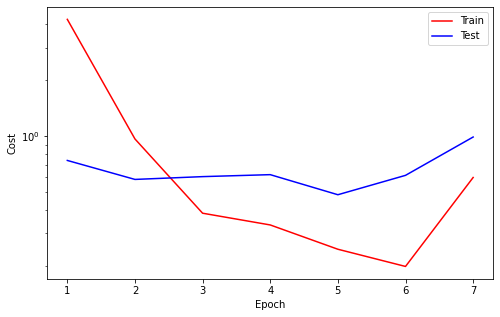

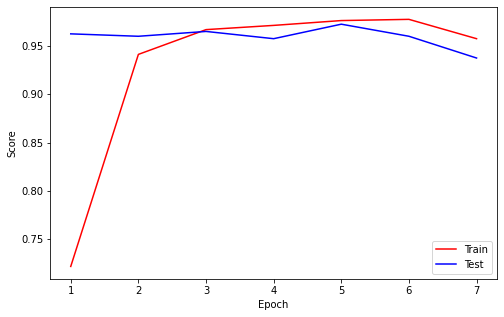

In [15]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Phase 2 : Fine-tuning (lr dikecilin + patience ditambah)

In [16]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5) # 10 pangkat -5

callback.reset_early_stop() # mereset early patience yg telah dilakukan sebelumnya
callback.early_stop_patience = 5

Train:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.1251 | Test_cost  = 0.5066 | Train_score = 0.9831 | Test_score = 0.9650 |
==> EarlyStop patience =  1 | Best test_score: 0.9725


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.0825 | Test_cost  = 0.4871 | Train_score = 0.9919 | Test_score = 0.9700 |
==> EarlyStop patience =  2 | Best test_score: 0.9725


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1092 | Test_cost  = 0.4926 | Train_score = 0.9825 | Test_score = 0.9700 |
==> EarlyStop patience =  3 | Best test_score: 0.9725


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.0400 | Test_cost  = 0.4628 | Train_score = 0.9900 | Test_score = 0.9700 |
==> EarlyStop patience =  4 | Best test_score: 0.9725


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.0473 | Test_cost  = 0.4872 | Train_score = 0.9925 | Test_score = 0.9700 |
==> EarlyStop patience =  5 | Best test_score: 0.9725
==> Execute Early Stopping at epoch: 12 | Best test_score: 0.9725
==> Best model is saved at model


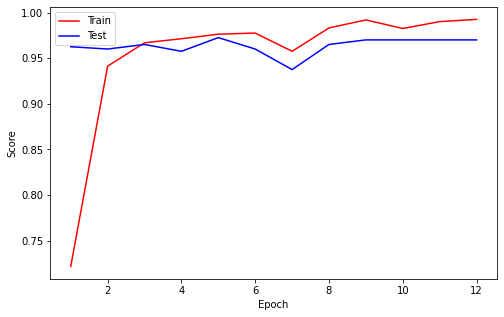

In [17]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_score()
    break

## Predict

In [18]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0, 0, 3, 2, 3, 3, 3, 3, 0, 1, 1, 1, 2, 3, 0, 1, 0, 3, 1, 3, 3, 1, 2, 3,
        0, 0, 0, 1, 3, 1, 2, 2, 1, 0, 3, 1, 0, 0, 1, 0, 3, 3, 1, 0, 0, 2, 2, 2,
        3, 0, 0, 1, 1, 1, 0, 2, 3, 3, 3, 3, 2, 3, 1, 0, 1, 2, 1, 3, 0, 2, 0, 2,
        3, 2, 3, 1, 0, 0, 1, 3, 3, 1, 3, 0, 2, 2, 1, 2, 1, 1, 1, 0, 2, 0, 0, 2,
        1, 0, 0, 1, 2, 3, 0, 1, 2, 3, 2, 0, 2, 0, 2, 0, 1, 1, 0, 3, 2, 2, 1, 1,
        2, 3, 0, 1, 2, 1, 3, 3], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

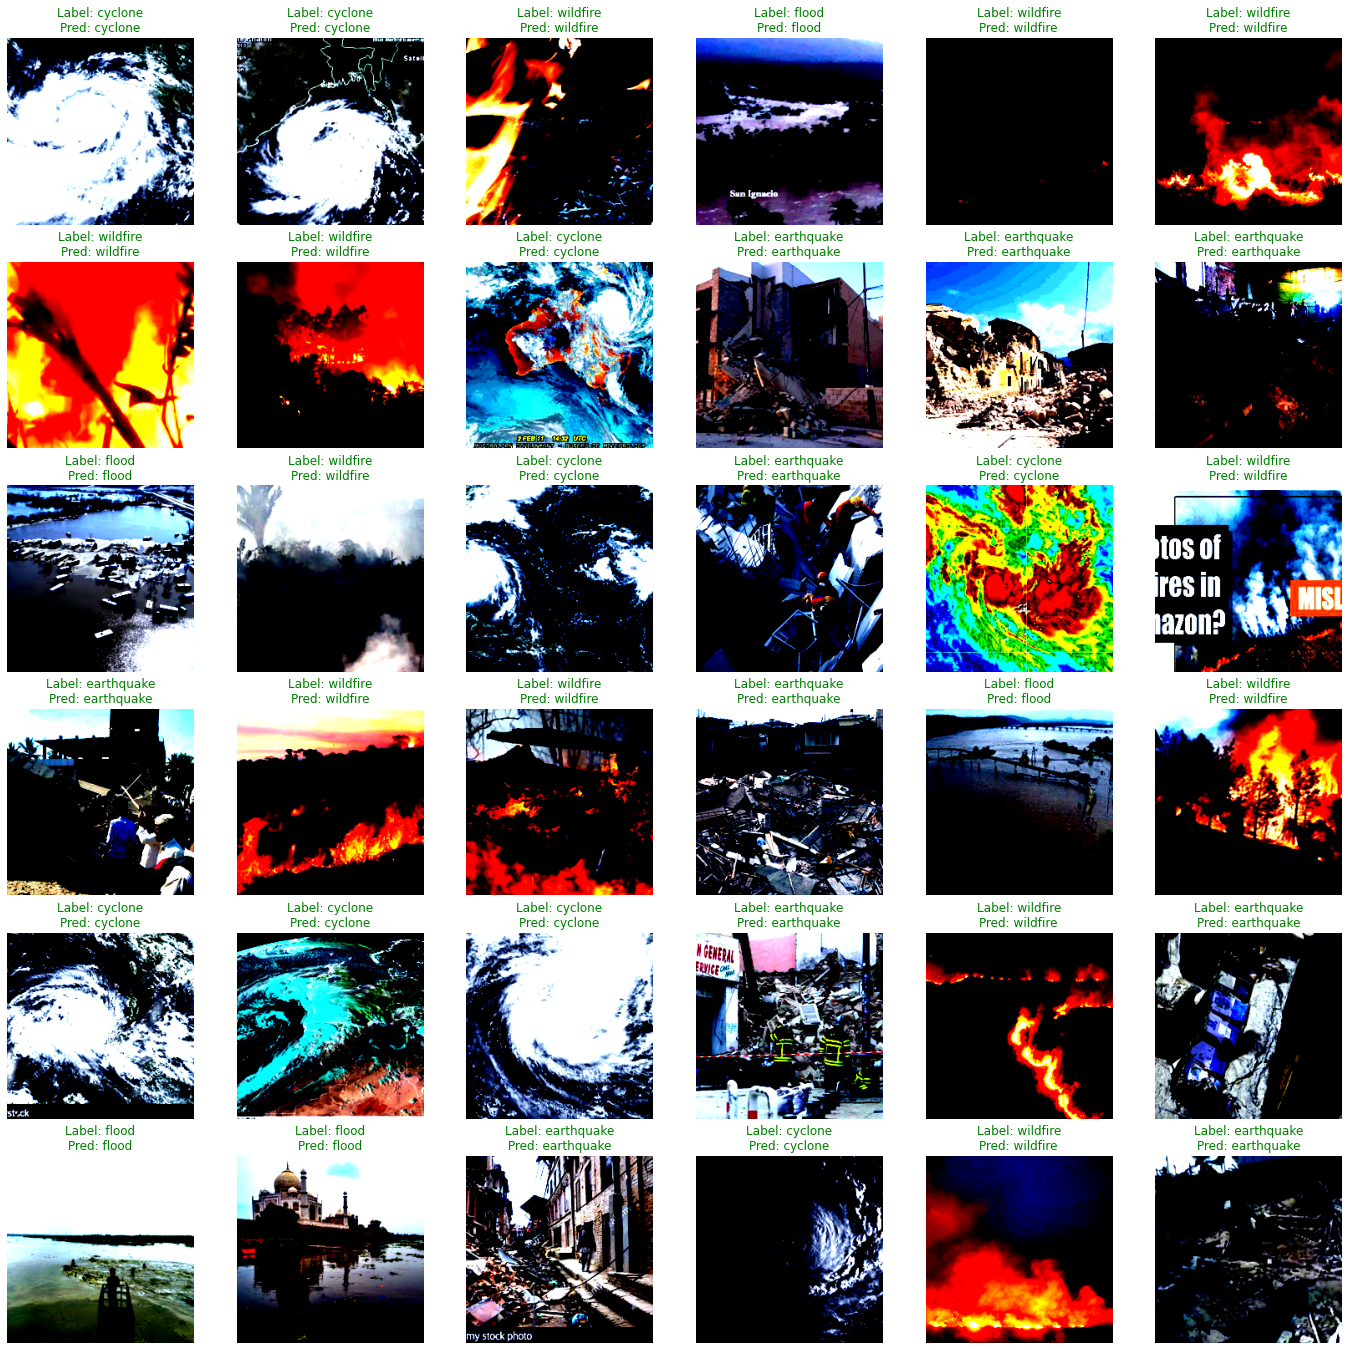

In [19]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color":'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
    ax.axis("off");